In [ ]:
!pip install tensorflow==2.15.0

In [2]:
# 2.15.0 버전이 나와야 함

import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
# 이미지 처리
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# json 파일 처리
import json

In [7]:
# 파일 존재 여부 확인용
import os

In [8]:
# Train 데이터에서 훈련용 데이터와 검증용 데이터 분리
from sklearn.model_selection import train_test_split

In [9]:
# 모델
from tensorflow import keras

In [10]:
# 랜덤숫자 생성
import random

# 변수 목록

In [11]:
os.chdir('/content/drive/MyDrive/[perst]데이터셋/MachineLearningProject/02_Fashion Type Classification Model')

In [12]:
male_female = "Male"

In [13]:
part_string = ["Background", "Outer", "Top", "Bottom", "Onepiece"]

In [16]:
ori_dir_name = "./Dataset/Musinsa_Dataset/Train-Test/" + male_female + "/Test/"
# part_dir_name = "./Dataset/Musinsa_Dataset/Train-Test_0916/" + male_female + "/" + part_string[part_index] + "/Test/"

img_width = 200
img_height = 200

part_width = 100
part_height = 100

model_dir_name = './Model/' # 학습 모델이 저장될 디렉토리명

In [18]:
if male_female == "Male":
  label_name = ['Gofcore', 'Golf', 'Dandy', 'Minimal', 'Business-Casual', 'Street', 'Sporty', 'Chic', 'Amekaji', 'Casual']
elif male_female == "Female":
  label_name = ['Girlish', 'Gofcore', 'Golf', 'Retro', 'Romantic', 'Business-Casual', 'Street', 'Sporty', 'Chic', 'Amekaji', 'Casual']
else:
  print("Dir name is Wrong!!")

print(label_name)

['Gofcore', 'Golf', 'Dandy', 'Minimal', 'Business-Casual', 'Street', 'Sporty', 'Chic', 'Amekaji', 'Casual']


# 모델 목록

In [19]:
seg_model_path = model_dir_name + "poly_seg_model_0428_02.keras"

In [20]:
outer_model_path = model_dir_name + 'fashion_classification_male_1004_01_outer.keras'
top_model_path = model_dir_name + 'fashion_classification_male_1005_01_top.keras'
bottom_model_path = model_dir_name + 'fashion_classification_male_1005_02_bottom.keras'
onepiece_model_path = model_dir_name + 'fashion_classification_male_1005_03_onepiece.keras'

# 원본 Test 데이터 불러오기

In [26]:
print(len(os.listdir(ori_dir_name + "Image")))
# 3697

3697


In [27]:
print(len(os.listdir(ori_dir_name + "Json")))
# 3697

3697


In [28]:
x_test_all = []
y_true_ori = []

for i in range(0, 3698):
    img_path = ori_dir_name + "Image/" + str(i) + ".jpg"
    label_path = ori_dir_name + "Json/" + str(i) + ".json"

    if not os.path.isfile(img_path):
        continue
    if not os.path.isfile(label_path):
        continue

    # json 파일 로드
    with open(label_path, "r") as loadfile:
      label_file = json.load(loadfile)
    if label_file is None:
        print(str(i) + ".json File Load Failed!!")
        break


    if male_female == "Male":
      if label_file['Labeling'] == 'Romantic': # Male에서 Romantic은 안쓴다
        print("File Skip : Romantic")
        continue

    # 이미지 파일 로드
    img_file_color = cv2.imread(img_path)
    if img_file_color is None:
        print(str(i) + ".jpg File Load Failed!!")
        break

    # 이미지 파일을 흑백으로 변환
    # img_file_gray = cv2.cvtColor(img_file_color, cv2.COLOR_BGR2GRAY)


    x_test_all.append(img_file_color)
    y_true_ori.append(label_file)


    if len(y_true_ori)%500 == 0: # 진행도 확인용
        print(str(len(y_true_ori)) + "개 파일 읽기 완료")


print("Complete")


500개 파일 읽기 완료
1000개 파일 읽기 완료
File Skip : Romantic
1500개 파일 읽기 완료
2000개 파일 읽기 완료
2500개 파일 읽기 완료
3000개 파일 읽기 완료
3500개 파일 읽기 완료
Complete


# 학습을 위해 X,Y데이터 형식 변경

In [29]:
x_test_all = np.array(x_test_all)
x_test_all.shape

(3696, 200, 200, 3)

In [30]:
y_true_all = []

for item in y_true_ori:
  label_num = label_name.index(item['Labeling'])

  y_true_all.append(label_num)

print(y_true_all[0])

0


In [31]:
y_true_all = np.array(y_true_all)
y_true_all.shape

(3696,)

In [32]:
y_true_all = y_true_all.astype('uint8')
y_true_all.dtype

dtype('uint8')


# 이미지 세그멘테이션

## 마스크 생성

In [33]:
# 데이터 크기 확인

seg_model = keras.models.load_model(seg_model_path)
print(x_test_all.shape)

print("Complete")

(3696, 200, 200, 3)
Complete


In [34]:
# 예측 진행
seg_preds = seg_model.predict(x_test_all)
print("Complete")

116/116 [==============================] - 45s 288ms/step
Complete


In [35]:
# 예측 결과를 마스크로 생성하고 저장
all_mask_list = []

for i in range(0, len(seg_preds)):
    total_mask = seg_preds[i].argmax(axis=-1)
    all_mask_list.append(total_mask)

all_mask_list = np.array(all_mask_list)
print("Complete")

Complete


['Background', 'Outer', 'Top', 'Bottom', 'Onepiece']


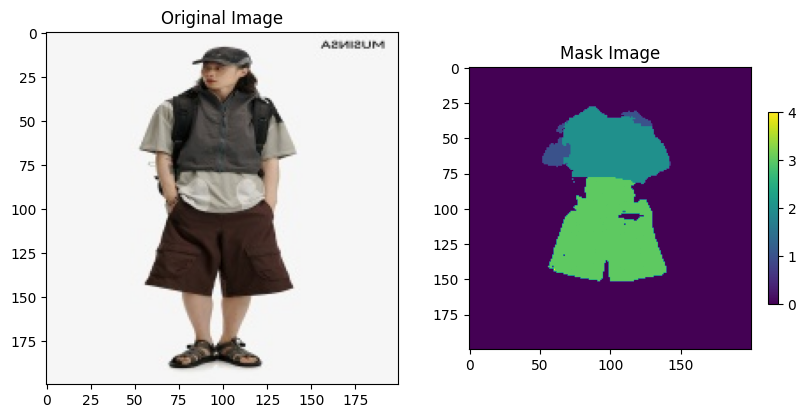

In [36]:
# 마스크 형태 확인
print(part_string)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(x_test_all[0], cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(all_mask_list[0])
plt.clim(0, 4)
plt.colorbar(shrink=0.5)
plt.title("Mask Image")

plt.show()

# 이미지의 각각 part 추출

In [39]:
def img_crop(img, mask, img_width, img_height):
  x1 = img_width
  y1 = img_height
  x2 = 0
  y2 = 0

  for y in range(0, img_height):
        for x in range(0, img_width):
            if mask[y][x] == 1:
                if x < x1:
                    x1 = x
                elif x > x2:
                    x2 = x

                if y < y1:
                    y1 = y
                elif y > y2:
                    y2 = y

  x = x1
  y = y1
  w = x2-x1
  h = y2-y1

  if h < 10 or w < 10:
    return None
  else:
    croped_img = img[y:y+h, x:x+w]
    return croped_img


## 1 : Outer

In [40]:
# 1 : Outer
part_index = 1

outer_img_list = []
not_outer_index = []

for i in range(0, len(all_mask_list)):
  if (i%500) == 0: # 진행도 확인용
    print(str(i+1) + "번째 이미지 작업중...")

  if part_index not in all_mask_list[i]:
    not_outer_index.append(i)
    continue
  else:
    outer_mask = np.zeros(all_mask_list[i].shape, dtype=np.uint8)
    outer_mask[all_mask_list[i] == part_index] = 1

  result = img_crop(x_test_all[i], outer_mask, img_width, img_height)
  if result is None:
    not_outer_index.append(i)
    continue
  else:
    result_resize = cv2.resize(result, dsize=(part_height, part_width), interpolation=cv2.INTER_AREA)
    result_resize = np.array(result_resize)
    outer_img_list.append(result_resize)

print("Complete")


1번째 이미지 작업중...
501번째 이미지 작업중...
1001번째 이미지 작업중...
1501번째 이미지 작업중...
2001번째 이미지 작업중...
2501번째 이미지 작업중...
3001번째 이미지 작업중...
3501번째 이미지 작업중...
Complete


In [41]:
outer_img_list = np.array(outer_img_list)

print(outer_img_list.shape)
print(len(not_outer_index))

(3113, 100, 100, 3)
583


## 2 : Top

In [42]:
# 2 : Top
part_index = 2

top_img_list = []
not_top_index = []

for i in range(0, len(all_mask_list)):
  if (i%500) == 0: # 진행도 확인용
    print(str(i+1) + "번째 이미지 작업중...")

  if part_index not in all_mask_list[i]:
    not_top_index.append(i)
    continue
  else:
    top_mask = np.zeros(all_mask_list[i].shape, dtype=np.uint8)
    top_mask[all_mask_list[i] == part_index] = 1

  result = img_crop(x_test_all[i], top_mask, img_width, img_height)
  if result is None:
    not_top_index.append(i)
    continue
  else:
    result_resize = cv2.resize(result, dsize=(part_height, part_width), interpolation=cv2.INTER_AREA)
    result_resize = np.array(result_resize)
    top_img_list.append(result_resize)

print("Complete")


1번째 이미지 작업중...
501번째 이미지 작업중...
1001번째 이미지 작업중...
1501번째 이미지 작업중...
2001번째 이미지 작업중...
2501번째 이미지 작업중...
3001번째 이미지 작업중...
3501번째 이미지 작업중...
Complete


In [43]:
top_img_list = np.array(top_img_list)

print(top_img_list.shape)
print(len(not_top_index))

(3551, 100, 100, 3)
145


## 3 : Bottom

In [44]:
# 3 : Bottom
part_index = 3

bottom_img_list = []
not_bottom_index = []

for i in range(0, len(all_mask_list)):
  if (i%500) == 0: # 진행도 확인용
    print(str(i+1) + "번째 이미지 작업중...")

  if part_index not in all_mask_list[i]:
    not_bottom_index.append(i)
    continue
  else:
    bottom_mask = np.zeros(all_mask_list[i].shape, dtype=np.uint8)
    bottom_mask[all_mask_list[i] == part_index] = 1

  result = img_crop(x_test_all[i], bottom_mask, img_width, img_height)
  if result is None:
    not_bottom_index.append(i)
    continue
  else:
    result_resize = cv2.resize(result, dsize=(part_height, part_width), interpolation=cv2.INTER_AREA)
    result_resize = np.array(result_resize)
    bottom_img_list.append(result_resize)

print("Complete")


1번째 이미지 작업중...
501번째 이미지 작업중...
1001번째 이미지 작업중...
1501번째 이미지 작업중...
2001번째 이미지 작업중...
2501번째 이미지 작업중...
3001번째 이미지 작업중...
3501번째 이미지 작업중...
Complete


In [45]:
bottom_img_list = np.array(bottom_img_list)

print(bottom_img_list.shape)
print(len(not_bottom_index))

(3338, 100, 100, 3)
358


## 4 : Onepiece

In [46]:
# 4 : Onepiece
part_index = 4

onepiece_img_list = []
not_onepiece_index = []

for i in range(0, len(all_mask_list)):
  if (i%500) == 0: # 진행도 확인용
    print(str(i+1) + "번째 이미지 작업중...")

  if part_index not in all_mask_list[i]:
    not_onepiece_index.append(i)
    continue
  else:
    onepiece_mask = np.zeros(all_mask_list[i].shape, dtype=np.uint8)
    onepiece_mask[all_mask_list[i] == part_index] = 1

  result = img_crop(x_test_all[i], onepiece_mask, img_width, img_height)
  if result is None:
    not_onepiece_index.append(i)
    continue
  else:
    result_resize = cv2.resize(result, dsize=(part_height, part_width), interpolation=cv2.INTER_AREA)
    result_resize = np.array(result_resize)
    onepiece_img_list.append(result_resize)

print("Complete")


1번째 이미지 작업중...
501번째 이미지 작업중...
1001번째 이미지 작업중...
1501번째 이미지 작업중...
2001번째 이미지 작업중...
2501번째 이미지 작업중...
3001번째 이미지 작업중...
3501번째 이미지 작업중...
Complete


In [47]:
onepiece_img_list = np.array(onepiece_img_list)

print(onepiece_img_list.shape)
print(len(not_onepiece_index))

(1248, 100, 100, 3)
2448


# 각 파트 예측

## Outer

In [48]:
outer_model = keras.models.load_model(outer_model_path)
outer_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           4160      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 47, 47, 192)          110784    ['conv2d_1[0][0]']            
                                                                                          

In [49]:
outer_preds = outer_model.predict(outer_img_list)

98/98 [==============================] - 7s 37ms/step


In [50]:
outer_preds.shape

(3113, 10)

In [51]:
outer_pred_label = []
outer_pred_max = []
outer_pred_copy = []
k = 0

for i in range(0, len(y_true_all)):
  if i in not_outer_index:
    outer_pred_label.append(None)
    outer_pred_max.append(None)
    outer_pred_copy.append(None)
  else:
    pred_label = np.argmax(outer_preds[k])
    pred_max = np.max(outer_preds[k])

    outer_pred_label.append(pred_label)
    outer_pred_max.append(pred_max)
    outer_pred_copy.append(outer_preds[k])

    k = k+1

print(len(outer_pred_label))
print(len(outer_pred_max))
print(len(outer_pred_copy))

3696
3696
3696


## Top

In [52]:
top_model = keras.models.load_model(top_model_path)
top_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           4160      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 47, 47, 192)          110784    ['conv2d_1[0][0]']            
                                                                                          

In [53]:
top_preds = top_model.predict(top_img_list)

111/111 [==============================] - 5s 39ms/step


In [54]:
top_preds.shape

(3551, 10)

In [56]:
top_pred_label = []
top_pred_max = []
top_pred_copy = []
k = 0

for i in range(0, len(y_true_all)):
  if i in not_top_index:
    top_pred_label.append(None)
    top_pred_max.append(None)
    top_pred_copy.append(None)
  else:
    pred_label = np.argmax(top_preds[k])
    pred_max = np.max(top_preds[k])

    top_pred_label.append(pred_label)
    top_pred_max.append(pred_max)
    top_pred_copy.append(top_preds[k])

    k = k+1

print(len(top_pred_label))
print(len(top_pred_max))
print(len(top_pred_copy))

3696
3696
3696


## Bottom

In [57]:
bottom_model = keras.models.load_model(bottom_model_path)
bottom_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           4160      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 47, 47, 192)          110784    ['conv2d_1[0][0]']            
                                                                                          

In [58]:
bottom_preds = bottom_model.predict(bottom_img_list)

105/105 [==============================] - 5s 39ms/step


In [59]:
bottom_preds.shape

(3338, 10)

In [60]:
bottom_pred_label = []
bottom_pred_max = []
bottom_pred_copy = []
k = 0

for i in range(0, len(y_true_all)):
  if i in not_bottom_index:
    bottom_pred_label.append(None)
    bottom_pred_max.append(None)
    bottom_pred_copy.append(None)
  else:
    pred_label = np.argmax(bottom_preds[k])
    pred_max = np.max(bottom_preds[k])

    bottom_pred_label.append(pred_label)
    bottom_pred_max.append(pred_max)
    bottom_pred_copy.append(bottom_preds[k])

    k = k+1

print(len(bottom_pred_label))
print(len(bottom_pred_max))
print(len(bottom_pred_copy))

3696
3696
3696


## Onepiece

In [61]:
onepiece_model = keras.models.load_model(onepiece_model_path)
onepiece_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           4160      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 47, 47, 192)          110784    ['conv2d_1[0][0]']            
                                                                                          

In [62]:
onepiece_preds = onepiece_model.predict(onepiece_img_list)

39/39 [==============================] - 1s 21ms/step


In [63]:
onepiece_preds.shape

(1248, 10)

In [64]:
onepiece_pred_label = []
onepiece_pred_max = []
onepiece_pred_copy = []
k = 0

for i in range(0, len(y_true_all)):
  if i in not_onepiece_index:
    onepiece_pred_label.append(None)
    onepiece_pred_max.append(None)
    onepiece_pred_copy.append(None)
  else:
    pred_label = np.argmax(onepiece_preds[k])
    pred_max = np.max(onepiece_preds[k])

    onepiece_pred_label.append(pred_label)
    onepiece_pred_max.append(pred_max)
    onepiece_pred_copy.append(onepiece_preds[k])

    k = k+1

print(len(onepiece_pred_label))
print(len(onepiece_pred_max))
print(len(onepiece_pred_copy))

3696
3696
3696


# 파트 통합 예측

## 1개 Test 데이터 예측결과 확인

In [65]:
y_true_all.shape

(3696,)

Random Number :  1933


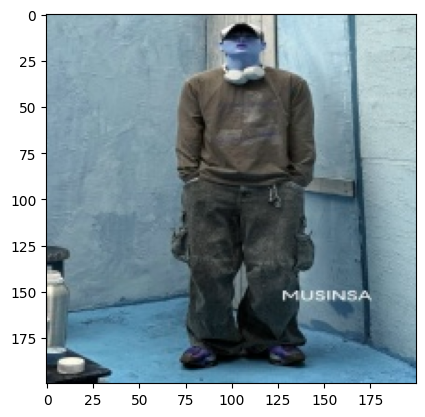

True Label :  Street
Outer :  Street  /  0.24510641
Top :  Sporty  /  0.1849543
Bottom :  Street  /  0.23036502

Result


In [70]:
num = random.randint(0, 3696)
print("Random Number : ", num)

plt.imshow(x_test_all[num])
plt.show()

print("True Label : ", label_name[y_true_all[num]])

if num not in not_outer_index:
  pred_label = outer_pred_label[num]
  pred_max = outer_pred_max[num]
  print("Outer : ", label_name[pred_label], " / ", pred_max)

if num not in not_top_index:
  pred_label = top_pred_label[num]
  pred_max = top_pred_max[num]
  print("Top : ", label_name[pred_label], " / ", pred_max)

if num not in not_bottom_index:
  pred_label = bottom_pred_label[num]
  pred_max = bottom_pred_max[num]
  print("Bottom : ", label_name[pred_label], " / ", pred_max)

if num not in not_onepiece_index:
  pred_label = onepiece_pred_label[num]
  pred_max = onepiece_pred_max[num]
  print("Onepiece : ", label_name[pred_label], " / ", pred_max)

print()
print("Result")

## 전체 Test 데이터 예측결과 확인

In [67]:
y_true = []
y_preds_index = []
y_preds = []

for i in range(0, len(x_test_all)):
  best_max = 0
  best_index = None
  best_preds = None

  if (i%500) == 0: # 진행도 확인용
    print(str(i+1) + "번째 이미지 작업중...")

  if i not in not_outer_index:
    outer_label = outer_pred_label[i]
    outer_max = outer_pred_max[i]
    if outer_max > best_max:
      best_max = outer_max
      best_index = outer_label
      best_preds = outer_pred_copy[i]

  if i not in not_top_index:
    top_label = top_pred_label[i]
    top_max = top_pred_max[i]
    if top_max > best_max:
      best_max = top_max
      best_index = top_label
      best_preds = top_pred_copy[i]

  if i not in not_bottom_index:
    bottom_label = bottom_pred_label[i]
    bottom_max = bottom_pred_max[i]
    if bottom_max > best_max:
      best_max = bottom_max
      best_index = bottom_label
      best_preds = bottom_pred_copy[i]

  if i not in not_onepiece_index:
    onepiece_label = onepiece_pred_label[i]
    onepiece_max = onepiece_pred_max[i]
    if onepiece_max > best_max:
      best_max = onepiece_max
      best_index = onepiece_label
      best_preds = onepiece_pred_copy[i]

  if best_index is None:
    continue
  else:
    y_true.append(y_true_all[i])
    y_preds_index.append(best_index)
    y_preds.append(best_preds)

print("Complete")

1번째 이미지 작업중...
501번째 이미지 작업중...
1001번째 이미지 작업중...
1501번째 이미지 작업중...
2001번째 이미지 작업중...
2501번째 이미지 작업중...
3001번째 이미지 작업중...
3501번째 이미지 작업중...
Complete


In [68]:
y_true = np.array(y_true)
y_preds = np.array(y_preds)

print(y_true.shape)
print(y_preds.shape)

(3696,)
(3696, 10)


In [69]:
# 정확도 계산
# sparse_categorical_accuracy

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_true, y_preds)
print("Sparse Categorical Accuracy : ", acc.result().numpy())

Sparse Categorical Accuracy :  0.33982685
